In [2]:
# 3rd party
import tensorflow as tf
import lightkurve as lk
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

from scipy.interpolate import interp1d

In [3]:
tce_tbl_fp = Path(
    "/Users/jochoa4/Projects/exoplanet_transit_classification/ephemeris_tables/preprocessing_tce_tables/tess_2min_tces_dv_s1-s68_all_msectors_11-29-2023_2157_newlabels_nebs_npcs_bds_ebsntps_to_unks.csv"
)

tce_tbl = pd.read_csv(tce_tbl_fp)
tce_tbl = tce_tbl.loc[
        tce_tbl["label"].isin(["EB", "KP", "CP", "NTP", "NEB", "NPC"])
]
tce_tbl = tce_tbl.rename(columns={"uid": "tce_uid", "label": "disposition", "uid": "tce_uid"})

/var/folders/_z/srkh35f94rd_6jrkc3kv29hm0000gp/T/ipykernel_97581/4188963064.py:5: DtypeWarning: Columns (364,366,367,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  tce_tbl = pd.read_csv(tce_tbl_fp)


### Investigating Neg Dispositions (NTP, NEB, NPC) overlap w/ Pos Dispositions (EB, KP, CP) at the target, sector_run level

In [6]:
t_sr_groups = tce_tbl.groupby(["target_id", "sector_run"])

Filter for target, sector_runs that have both Pos and Neg disposition TCEs

In [9]:
mixed_t_sr_groups = t_sr_groups.filter(
    lambda g: 
        (np.isin(np.array(["EB", "CP", "KP"]), g["disposition"].unique()).any())
        and 
        (np.isin(np.array(["NTP", "NEB", "NPC"]), g["disposition"].unique()).any())
).groupby(["target_id", "sector_run"])

(2259, 43054)

### Specific (target, sector_run) pairs

In [4]:
target, sector_run = 198242678, "14-19" # 30034081, "7"

In [5]:
sector_run_arr = []

if "-" in sector_run:
    start_sector, end_sector = [
        int(sector) for sector in sector_run.split("-")
    ]
    sector_run_arr = [
        sector for sector in range(start_sector, end_sector + 1)
    ]
else:
    sector_run_arr = [int(sector_run)]

# find light curve data for target, sector_run pair
search_lc_res = lk.search_lightcurve(
    target=f"tic{target}",
    mission="TESS",
    author=("TESS-SPOC", "SPOC"),
    exptime=120,
    cadence="long",
    sector=sector_run_arr,
)

In [13]:
lcfs_def = search_lc_res.download_all(
    quality_bitmask="default", flux_column="pdcsap_flux"
)

lcfs_none = search_lc_res.download_all(
    quality_bitmask="none", flux_column="pdcsap_flux"
)

found_sectors = [int(el.split(' ')[-1]) for el in search_lc_res.table["mission"]]

In [14]:
found_sectors

[14, 16, 17, 18, 19]

In [17]:
lcf_def = lcfs_def[0]

lcf_def = lk.LightCurve({"time": np.array(lcf_def.time.value), "flux": np.array(lcf_def.flux.value)})

lcf_none = lcfs_none[0]

lcf_none = lk.LightCurve({"time": np.array(lcf_none.time.value), "flux": np.array(lcf_none.flux.value)})

print(f"default mask max_diff: {np.max(np.diff(lcf_def.time.value))}")
print(f"no mask max_diff: {np.max(np.diff(lcf_none.time.value))}")
print(len(lcf_def.time.value))
print(len(lcf_none.time.value))


default mask max_diff: 0.9555375604454639
no mask max_diff: 0.9499821161348336
18424
18654


In [ ]:
lcf_fits_fp = "/Users/jochoa4/Downloads/MAST_2025-06-09T2246/TESS/tess2019279210107-s0017-0000000198242678-0161-s/tess2019279210107-s0017-0000000198242678-0161-s_lc.fits"


In [20]:
import astropy.io.fits as fits
lcf = fits.open(lcf_fits_fp)

In [ ]:
lcf_def

In [22]:
lcf.info()

Filename: /Users/jochoa4/Downloads/MAST_2025-06-09T2246/TESS/tess2019279210107-s0017-0000000198242678-0161-s/tess2019279210107-s0017-0000000198242678-0161-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18012R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   


In [23]:
from astropy.table import Table
table = Table.read(lcf_fits_fp)

In [51]:
type(table["TIME"])

astropy.table.column.MaskedColumn

In [55]:
raw_time, np_time = table["TIME"], np.array(table["TIME"])
len(raw_time) == len(np_time)

True

In [ ]:
np.max(np.ma.diff(raw_time)), np.max(np.diff(np_time[np.where(np.isfinite(np_time))[0]))

In [66]:
len(np.ma.diff(raw_time))

18011

In [69]:
len(np.diff(np_time))

18011

In [70]:
raw_time[0], raw_time[-1]

(1764.6778258441836, 1789.6931248626518)

In [72]:
exp_num_idxs = len(np.arange(raw_time[0], raw_time[-1], 2 / 1440))
exp_num_idxs

18012

In [73]:
len(raw_time[np.isfinite(raw_time)])

16982

(0.001388899230505558, 0.001388881300954381)

In [39]:
len(table["TIME"]) == len(np.array(table["TIME"]))


True

In [40]:
time = np.array(table["TIME"])

In [41]:
time_diff = np.diff(np.array(table["TIME"]))

In [48]:
nan_time_idxs = np.where((~np.isfinite(time)))[0]
nan_time_idxs

array([ 8364,  8365,  8366, ...,  9391, 17645, 17646])

In [ ]:
time_nan = 

In [46]:
len(nan_time_idxs)

1030

In [ ]:
nan_time_idxs = 

In [52]:
nan_time_idxs = np.where(((np.isnan(np.array(table["TIME"]))) == (~np.isfinite(np.array(table["TIME"])))).all())

(array([0]),)

In [37]:
np.isfinite(np.array(table["TIME"]))

array([ True,  True,  True, ...,  True,  True,  True])

In [82]:
lcf_def = lcfs_def[2]
lcf_def

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1764.6833813693875,1.0791109e+05,4.5149025e+01,-1.0525171e-03,386805,2058.87129,266.22975,1.3893019e+05,4.3232876e+01,2.1284526e+03,1.2674622e+01,1.0791109e+05,4.5149025e+01,0,———,———,———,———,2058.87129,2.7773477e-04,266.22975,3.1899914e-04,1.1205494e-02,5.1924460e-02
1764.6847702506886,1.0790324e+05,4.5142208e+01,-1.0525241e-03,386806,2058.87123,266.22698,1.3892645e+05,4.3226345e+01,2.1375220e+03,1.2644804e+01,1.0790324e+05,4.5142208e+01,0,———,———,———,———,2058.87123,2.7754216e-04,266.22698,3.1902394e-04,1.0921710e-02,4.9388994e-02
1764.6861591319896,1.0785036e+05,4.5157101e+01,-1.0525311e-03,386807,2058.86687,266.22727,1.3886205e+05,4.3240608e+01,2.1504407e+03,1.2714690e+01,1.0785036e+05,4.5157101e+01,0,———,———,———,———,2058.86687,2.7752231e-04,266.22727,3.1904268e-04,5.0868765e-03,4.9628641e-02
1764.6875480132912,1.0793118e+05,4.5155788e+01,-1.0525380e-03,386808,2058.87471,266.23153,1.3891358e+05,4.3239349e+01,2.1386104e+03,1.2703175e+01,1.0793118e+05,4.5155788e+01,0,———,———,———,———,2058.87471,2.7761204e-04,266.23153,3.1904620e-04,1.5811194e-02,5.5337731e-02
1764.688936894593,1.0788295e+05,4.5142960e+01,-1.0525450e-03,386809,2058.86974,266.22746,1.3884225e+05,4.3227066e+01,2.1337031e+03,1.2683372e+01,1.0788295e+05,4.5142960e+01,0,———,———,———,———,2058.86974,2.7781565e-04,266.22746,3.1932458e-04,9.3892375e-03,5.0588921e-02
1764.690325775894,1.0785216e+05,4.5153011e+01,-1.0525520e-03,386810,2058.86894,266.22732,1.3881416e+05,4.3236694e+01,2.1440244e+03,1.2693469e+01,1.0785216e+05,4.5153011e+01,0,———,———,———,———,2058.86894,2.7796972e-04,266.22732,3.1931282e-04,8.7993387e-03,4.9752053e-02
1764.691714657195,1.0796320e+05,4.5167110e+01,-1.0525590e-03,386811,2058.86985,266.22749,1.3891070e+05,4.3250191e+01,2.1335452e+03,1.2690621e+01,1.0796320e+05,4.5167110e+01,0,———,———,———,———,2058.86985,2.7767447e-04,266.22749,3.1927144e-04,9.4211334e-03,4.9416382e-02
1764.6931035384962,1.0797679e+05,4.5167591e+01,-1.0525660e-03,386812,2058.87411,266.22865,1.3890653e+05,4.3250652e+01,2.1547676e+03,1.2702180e+01,1.0797679e+05,4.5167591e+01,0,———,———,———,———,2058.87411,2.7781693e-04,266.22865,3.1919411e-04,1.3968344e-02,5.1046737e-02


In [78]:
len(lcf_def.time.value) == len(np.array(lcf_def.time.value))

True

In [83]:
lcf_def.time

<Time object: scale='tdb' format='btjd' value=[1764.68338137 1764.68477025 1764.68615913 ... 1789.69034707 1789.69173597
 1789.69312486]>

In [84]:
type(lcf_def.time.value)

numpy.ndarray

In [86]:
lcfs_def[2]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1764.6833813693875,1.0791109e+05,4.5149025e+01,-1.0525171e-03,386805,2058.87129,266.22975,1.3893019e+05,4.3232876e+01,2.1284526e+03,1.2674622e+01,1.0791109e+05,4.5149025e+01,0,———,———,———,———,2058.87129,2.7773477e-04,266.22975,3.1899914e-04,1.1205494e-02,5.1924460e-02
1764.6847702506886,1.0790324e+05,4.5142208e+01,-1.0525241e-03,386806,2058.87123,266.22698,1.3892645e+05,4.3226345e+01,2.1375220e+03,1.2644804e+01,1.0790324e+05,4.5142208e+01,0,———,———,———,———,2058.87123,2.7754216e-04,266.22698,3.1902394e-04,1.0921710e-02,4.9388994e-02
1764.6861591319896,1.0785036e+05,4.5157101e+01,-1.0525311e-03,386807,2058.86687,266.22727,1.3886205e+05,4.3240608e+01,2.1504407e+03,1.2714690e+01,1.0785036e+05,4.5157101e+01,0,———,———,———,———,2058.86687,2.7752231e-04,266.22727,3.1904268e-04,5.0868765e-03,4.9628641e-02
1764.6875480132912,1.0793118e+05,4.5155788e+01,-1.0525380e-03,386808,2058.87471,266.23153,1.3891358e+05,4.3239349e+01,2.1386104e+03,1.2703175e+01,1.0793118e+05,4.5155788e+01,0,———,———,———,———,2058.87471,2.7761204e-04,266.23153,3.1904620e-04,1.5811194e-02,5.5337731e-02
1764.688936894593,1.0788295e+05,4.5142960e+01,-1.0525450e-03,386809,2058.86974,266.22746,1.3884225e+05,4.3227066e+01,2.1337031e+03,1.2683372e+01,1.0788295e+05,4.5142960e+01,0,———,———,———,———,2058.86974,2.7781565e-04,266.22746,3.1932458e-04,9.3892375e-03,5.0588921e-02
1764.690325775894,1.0785216e+05,4.5153011e+01,-1.0525520e-03,386810,2058.86894,266.22732,1.3881416e+05,4.3236694e+01,2.1440244e+03,1.2693469e+01,1.0785216e+05,4.5153011e+01,0,———,———,———,———,2058.86894,2.7796972e-04,266.22732,3.1931282e-04,8.7993387e-03,4.9752053e-02
1764.691714657195,1.0796320e+05,4.5167110e+01,-1.0525590e-03,386811,2058.86985,266.22749,1.3891070e+05,4.3250191e+01,2.1335452e+03,1.2690621e+01,1.0796320e+05,4.5167110e+01,0,———,———,———,———,2058.86985,2.7767447e-04,266.22749,3.1927144e-04,9.4211334e-03,4.9416382e-02
1764.6931035384962,1.0797679e+05,4.5167591e+01,-1.0525660e-03,386812,2058.87411,266.22865,1.3890653e+05,4.3250652e+01,2.1547676e+03,1.2702180e+01,1.0797679e+05,4.5167591e+01,0,———,———,———,———,2058.87411,2.7781693e-04,266.22865,3.1919411e-04,1.3968344e-02,5.1046737e-02


In [91]:
cadenceno_none = lcfs_none[2].cadenceno

In [94]:
cadenceno_none

386801
386802
386803
386804
386805
386806
386807
386808
386809
386810
386811


In [101]:
time_skips = np.where(np.diff(lcfs_none[2].time.value) > (10 * 2 / 1440))[0]


for skip in time_skips:
    print(lcfs_none[2][skip - 5: skip + 5].time, lcfs_none[2][skip - 5: skip + 5].cadenceno)

[1776.2861436  1776.2875325  1776.28892139 1776.29031028 1776.29169918
 1776.29308807 1777.72225593 1777.72364481 1777.7250337  1777.72642259] cadenceno 
----------
    395159
    395160
    395161
    395162
    395163
    395164
    396193
    396194
    396195
    396196


In [95]:
len(lcfs_def[2].time.value)

16663

In [102]:
lcfs_none = search_lc_res.download_all(
    quality_bitmask="none", flux_column="pdcsap_flux"
)
lcfs_zero = search_lc_res.download_all(
    quality_bitmask=0, flux_column="pdcsap_flux"
)

In [106]:
print(len(lcfs_zero[0].time.value))
print(len(lcfs_none[0].time.value))
np.max(np.diff(lcfs_zero[0].time.value))

18654
18654


0.9499821161348336

## Testing interpolation/extrapolation

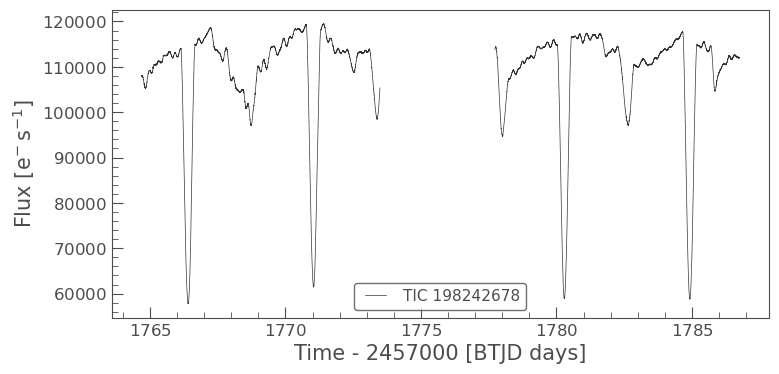

In [107]:
lcf_lk = lk.read(lcf_fits_fp)

lcf_lk.plot()

time_lk = lcf_lk.time.value
flux_lk = lcf_lk.flux.value


In [138]:
def fill_missing_tess_cadences(
    time: np.ndarray, strategy: str = ""
):

    if not isinstance(time, np.ndarray):
        print(f"time: {type(time)}")
        time = np.array(time)

    missing_cadence_mask = ~np.isfinite(time)

    n_cadences = len(time)
    valid_idxs = np.where(np.isfinite(time))[0]  # returns actual idxs, not mask

    if n_cadences == len(valid_idxs):
        return time, np.zeros_like(time).astype(bool)  # time has no missing values

    if strategy == "average":
        cadence = np.nanmean(np.diff(time[valid_idxs]))
    elif strategy == "median":
        cadence = np.nanmedian(np.diff(time[valid_idxs]))
    else:
        cadence = 2 / 1440  # 2mins in days for TESS

    # if first/last idx are valid, use directly else offset by cadnece * idx dist to start/end
    t_start = time[valid_idxs][0] - valid_idxs[0] * cadence
    t_end = time[valid_idxs][-1] + ((n_cadences - 1) - valid_idxs[-1]) * cadence

    time_filled = np.linspace(t_start, t_end, n_cadences)

    return time_filled, missing_cadence_mask

In [161]:
def fill_missing_flux(time, flux, cadence_mask):

    f = interp1d(
        time[(~cadence_mask)],
        flux[(~cadence_mask)],
        kind="linear",
        bounds_error=False,
        fill_value="extrapolate",  # assume_sorted=True
    )

    filled_flux = f(time)

    return filled_flux

In [175]:
def detrend_flux_using_sg_filter(lc, mask_in_transit, win_len, sigma, max_poly_order, penalty_weight, break_tolerance):
    """ Detrend timeseries by applying a Savitzky-Golay filter to a version of the timeseries where in-transit cadences
    are masked (i.e., not taken into account).

    Args:
        lc: lightcurve object, with raw timestamps and timeseries
        mask_in_transit: NumPy array, in-transit cadences are flagged as True
        win_len: int, number of points considered in the window
        sigma: outlier factor used to mask data points before detrending (i.e., x - med(flux) >= sigma * std(flux))
        max_poly_order: int, maximum polynomial order tested
        penalty_weight: float: weight given to model's complexity when using BIC for model selection
        break_tolerance: float, factor used to split the timeseries into smaller segments based on time interval between
            cadences (i.e., there's a split if diff(t_x) > break_tolerance * med(diff(T)))

    Returns:
        - time, NumPy array with timestamps
        - detrended_flux, NumPy array with detrended timeseries (i.e., detrended_flux = flux / trend)
        - trend, NumPy array with trend
        - models_info_df, pandas DataFrame with BIC scores for the fitted models
    """

    if mask_in_transit.all():
        time = lc.time.value
        trend = np.nanmedian(lc.flux.value) * np.ones_like(lc.flux.value)
        detrended_flux = lc.flux.value / trend
        trend = np.ones_like(lc.flux.value)
        models_info_df = pd.DataFrame({'poly_order': [0], 'bic_score': [np.nan]})

        return time, detrended_flux, trend, models_info_df

    n_samples = len(lc.flux.value)
    poly_order_arr = np.arange(0, max_poly_order + 1)
    best_bic, best_model = np.inf, 0
    lc_detrended = {poly_order: {'flux': None, 'trend': None, 'bic': np.nan} for poly_order in poly_order_arr}
    for poly_order in poly_order_arr:

        lc_sector_flatten, lc_sector_trend = lc.flatten(window_length=win_len, polyorder=poly_order, return_trend=True,
                                                        sigma=sigma, mask=mask_in_transit,
                                                        break_tolerance=break_tolerance)
        lc_detrended[poly_order]['flux'] = lc_sector_flatten.copy()
        lc_detrended[poly_order]['trend'] = lc_sector_trend.copy()

        bic_k = compute_bic(poly_order, n_samples, lc.flux.value, lc_sector_trend.flux.value,
                            penalty_weight=penalty_weight)
        lc_detrended[poly_order]['bic'] = bic_k
        if bic_k < best_bic:
            best_bic, best_model = bic_k, poly_order

    bic_scores = [lc_detrended[poly_order]['bic'] for poly_order in lc_detrended]
    models_info_df = pd.DataFrame({'poly_order': poly_order_arr, 'bic_score': bic_scores})
    models_info_df.sort_values(by='bic_score', ascending=True, inplace=True)
    models_info_df.set_index('poly_order', inplace=True)

    time, detrended_flux = lc_detrended[best_model]['flux'].time.value, lc_detrended[best_model]['flux'].flux.value
    trend = lc_detrended[best_model]['trend'].flux.value

    # remove median from trend (by time splits)
    dt = np.diff(time)
    cut = np.where(dt > break_tolerance * np.nanmedian(dt))[0] + 1
    low = np.append([0], cut)
    high = np.append(cut, len(time))
    for low_i, high_i in zip(low, high):
        trend[low_i: high_i] /= np.nanmedian(trend[low_i: high_i])

    return time, detrended_flux, trend, models_info_df

max diff mins: 2.0000016982885427
18012
18012
12620
18012
<class 'numpy.ndarray'>


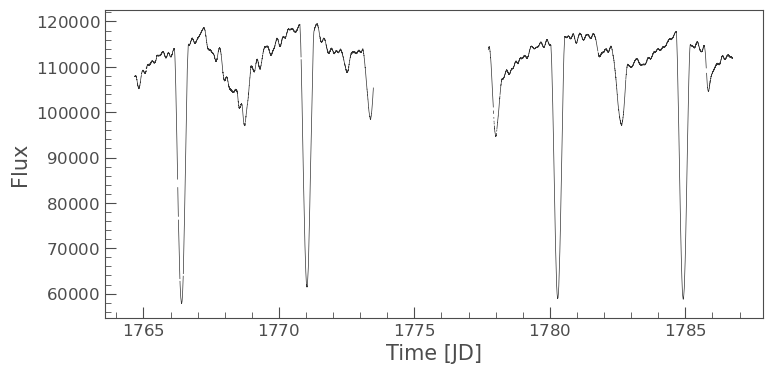

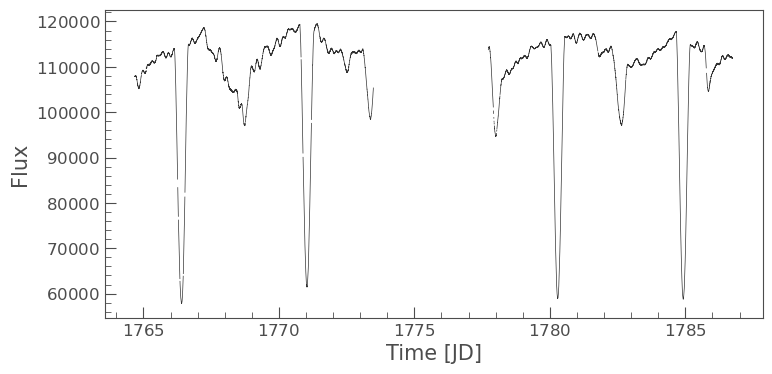

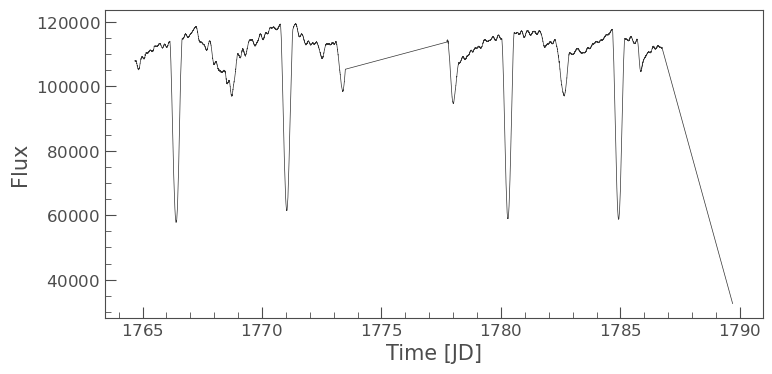

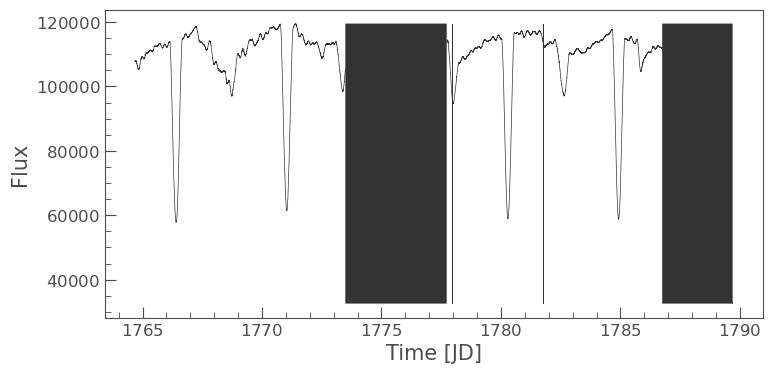

In [174]:
lcf_ap_table = Table.read(lcf_fits_fp, format="fits")

quality_ap = lcf_ap_table["QUALITY"].value
default_bitmask = 17087

time_ap_unproc = lcf_ap_table["TIME"].value.filled(np.nan)
flux_ap_unproc = lcf_ap_table["PDCSAP_FLUX"].value.filled(np.nan)

# lcf_ap_unproc = lk.LightCurve({"time": time_ap_unproc, "flux": flux_ap_unproc})
# lcf_ap_unproc.plot()
# time_ap_unproc = np.array(time_ap_unproc)
# flux_ap_unproc = np.array(flux_ap_unproc)

time_ap_proc, cadence_mask = fill_missing_tess_cadences(time_ap_unproc)
print(f"max diff mins: {np.max(np.diff(time_ap_proc) * 1440)}")
lcf_ap_time_proc = lk.LightCurve({"time": time_ap_proc, "flux": flux_ap_unproc})
lcf_ap_time_proc.plot()

valid_quality_idxs_ap = (default_bitmask & quality_ap) == 0
valid_flux_idxs_ap = np.isfinite(flux_ap_unproc)

cadence_mask |= ~valid_quality_idxs_ap
cadence_mask |= ~valid_flux_idxs_ap

flux_ap_proc = flux_ap_unproc.copy()
flux_ap_proc[cadence_mask] = np.nan

lcf_ap_proc = lk.LightCurve({"time": time_ap_proc, "flux": flux_ap_proc})
lcf_ap_proc.plot()
print(np.isfinite(lcf_ap_proc.time.value).sum())
print(len(lcf_ap_proc.time.value))

print(np.isfinite(lcf_ap_proc.flux.value).sum())
print(len(lcf_ap_proc.flux.value))

interp_flux = fill_missing_flux(time_ap_proc, flux_ap_proc, cadence_mask)
print(type(interp_flux))
lcf_ap_interp = lk.LightCurve({"time": time_ap_proc, "flux": interp_flux})

lcf_ap_interp.plot()
lcf_ap_interp.plot()

# plt.scatter(time_ap_proc, interp_flux)
# lk.LightCurve({"time": time_ap_proc[~cadence_mask], "flux": interp_flux[~cadence_mask]}).plot()
plt.fill_between(time_ap_proc, np.min(interp_flux), np.max(interp_flux), where=cadence_mask)
plt.show()
#detrend 


In [ ]:
detrend_time, detrend_flux, detrend_trend, _ = detrend_flux_using_sg_filter()